In [1]:
import torch
from torch import Tensor
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import numpy as np
import torch as t
import tqdm
#functional
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from functools import partial
import einops
import circuitsvis as cv
from src.game import Board, apply_best_moves, get_best_moves

# Graphing stuff

In [2]:
def to_numpy(tensor, flat=False):
    if type(tensor)!=torch.Tensor:
        return tensor
    if flat:
        return tensor.flatten().detach().cpu().numpy()
    else:
        return tensor.detach().cpu().numpy()

def imshow(tensor, xaxis=None, yaxis=None, animation_name='Snapshot', **kwargs):
    tensor = torch.squeeze(tensor)
    px.imshow(to_numpy(tensor, flat=False),aspect='auto', 
              labels={'x':xaxis, 'y':yaxis, 'animation_name':animation_name}, 
              **kwargs).show()
# Set default colour scheme
imshow = partial(imshow, color_continuous_scale='Blues')
# Creates good defaults for showing divergent colour scales (ie with both 
# positive and negative values, where 0 is white)
imshow_div = partial(imshow, color_continuous_scale='RdBu', color_continuous_midpoint=0.0)
# Presets a bunch of defaults to imshow to make it suitable for showing heatmaps 
# of activations with x axis being input 1 and y axis being input 2.
inputs_heatmap = partial(imshow, xaxis='Input 1', yaxis='Input 2', color_continuous_scale='RdBu', color_continuous_midpoint=0.0)

def line(x, y=None, hover=None, xaxis='', yaxis='', **kwargs):
    if type(y)==torch.Tensor:
        y = to_numpy(y, flat=True)
    if type(x)==torch.Tensor:
        x = to_numpy(x, flat=True)
    fig = px.line(x, y=y, hover_name=hover, **kwargs)
    fig.update_layout(xaxis_title=xaxis, yaxis_title=yaxis)
    fig.show()

def lines(lines_list, x=None, mode='lines', labels=None, xaxis='', yaxis='', title = '', log_y=False, hover=None, **kwargs):
    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    fig = go.Figure(layout={'title':title})
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if log_y:
        fig.update_layout(yaxis_type="log")
    fig.show()

# Training Config Stuff

In [3]:
cfg = HookedTransformerConfig(
    n_layers = 8,
    n_heads = 8,
    d_model = 128,
    d_head = 16,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=10,
    d_vocab_out=10,
    n_ctx=9,
    init_weights=True,
    device="cuda",
    seed = 1337,
)

lr = 1e-4
weight_decay = 1e-4
test_train_split = 0.8
epochs = 1000
batch_size = 4096



In [4]:

np_data = np.load('data/moves.npy')

In [5]:
np_data.shape

(3584, 11)

In [6]:
boards = [Board()]
game_list = apply_best_moves(boards)
moves = np.array([[10] + game.moves_played + [9] for game in game_list])

In [7]:
boards = [Board()]
game_list = apply_best_moves(boards)
moves = np.array([game.moves_played + [9] for game in game_list])

In [8]:
#load npy file
# np_data = np.load('data/moves.npy')
data = moves[:, :-1]
labels = moves[:, 1:]

print(len(data))
print(len(labels))
print(data[0])
print(labels[0])

3584
3584
[0 4 1 2 6 3 5 7 8]
[4 1 2 6 3 5 7 8 9]


In [9]:
encoded_labels = F.one_hot(t.tensor(labels))
print(encoded_labels)
print(t.sum(encoded_labels, axis=1))

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 0, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         [0,

In [10]:
encoded_data = F.one_hot(t.tensor(data))
print(encoded_data[1238])

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0]])


In [11]:
encoded_labels[0,:,:]

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [12]:
#data and labels as numpy arrays
data = np.array(data)
encoded_labels = np.array(encoded_labels)
#data and encoded_labels as tensors
data = t.from_numpy(data)
encoded_labels = t.from_numpy(encoded_labels).to(t.float)
total_data = list(zip(data, encoded_labels))
num_samples = len(total_data)
train_size = int(test_train_split * num_samples)
test_size = num_samples - train_size
split_data = list(t.utils.data.random_split(total_data, [train_size, test_size]))
train_pairs = split_data[0]
test_pairs= split_data[1]
train_data, train_labels = zip(*train_pairs)
test_data, test_labels = zip(*test_pairs)

train_data = t.stack(train_data).to(cfg.device)
train_labels = t.stack(train_labels).to(cfg.device)
test_data = t.stack(test_data).to(cfg.device)
test_labels = t.stack(test_labels).to(cfg.device)



#test train split
train_data = data[:int(len(data)*test_train_split)]
train_labels = encoded_labels[:int(len(data)*test_train_split)]
test_data = data[int(len(data)*test_train_split):]
test_labels = encoded_labels[int(len(data)*test_train_split):]

In [13]:
print(len(test_data))
print(len(test_labels))

717
717


In [14]:
def loss_fn(logits: Tensor, labels: Tensor):
    return t.nn.functional.cross_entropy(logits, labels)

In [15]:
ten = t.tensor([0,1]).to(t.float)
loss_fn(ten, ten)

tensor(0.3133)

In [16]:
train_data[0]

tensor([1, 7, 5, 2, 6, 3, 4, 8, 0], device='cuda:0')

In [17]:
seq = [10,0,5,2]

In [18]:
board = Board()

In [19]:
board.make_move(seq[-1])
board.draw_board()

|   |   | X |
|   |   |   |
|   |   |   |


In [20]:
def seq_is_matched(input: list[int], seq: list[int]) -> bool:
    return all(seq[i] == input[i] for i in range(len(seq)))

In [21]:
[seq for seq in seqs if seq_is_matched(seq, [4])]

NameError: name 'seqs' is not defined

In [ ]:
seqs = [game.moves_played for game in game_list]
seqs

[[0, 4, 1, 2, 6, 3, 5, 7, 8],
 [0, 4, 1, 2, 6, 3, 5, 8, 7],
 [0, 4, 2, 1, 7, 3, 5, 8, 6],
 [0, 4, 2, 1, 7, 5, 3, 6, 8],
 [0, 4, 2, 1, 7, 6, 3, 5, 8],
 [0, 4, 2, 1, 7, 6, 3, 8, 5],
 [0, 4, 2, 1, 7, 6, 5, 8, 3],
 [0, 4, 2, 1, 7, 6, 8, 5, 3],
 [0, 4, 2, 1, 7, 8, 3, 6, 5],
 [0, 4, 2, 1, 7, 8, 5, 3, 6],
 [0, 4, 2, 1, 7, 8, 5, 6, 3],
 [0, 4, 2, 1, 7, 8, 6, 3, 5],
 [0, 4, 3, 6, 2, 1, 7, 5, 8],
 [0, 4, 3, 6, 2, 1, 7, 8, 5],
 [0, 4, 5, 1, 7, 6, 2, 8, 3],
 [0, 4, 5, 1, 7, 8, 2, 3, 6],
 [0, 4, 5, 1, 7, 8, 2, 6, 3],
 [0, 4, 5, 1, 7, 8, 3, 6, 2],
 [0, 4, 5, 1, 7, 8, 6, 3, 2],
 [0, 4, 5, 2, 6, 3, 1, 7, 8],
 [0, 4, 5, 2, 6, 3, 1, 8, 7],
 [0, 4, 5, 2, 6, 3, 7, 8, 1],
 [0, 4, 5, 2, 6, 3, 8, 7, 1],
 [0, 4, 5, 7, 1, 2, 6, 3, 8],
 [0, 4, 5, 8, 1, 2, 6, 3, 7],
 [0, 4, 5, 8, 2, 1, 7, 3, 6],
 [0, 4, 5, 8, 2, 1, 7, 6, 3],
 [0, 4, 5, 8, 6, 3, 1, 2, 7],
 [0, 4, 5, 8, 6, 3, 2, 1, 7],
 [0, 4, 5, 8, 6, 3, 7, 1, 2],
 [0, 4, 5, 8, 6, 3, 7, 2, 1],
 [0, 4, 5, 8, 7, 1, 2, 3, 6],
 [0, 4, 5, 8, 7, 1, 2, 6, 3],
 [0, 4, 5,

In [ ]:
seq = [10,1]
output_seq = [1,9]
zeros = [0.] * 10
first_output = [0.] * 10
first_output[1] = 1.
second_output = [0.] * 10
second_output[9] = 1.
output = torch.tensor([first_output, second_output])


logit_base = torch.tensor([-10000000000.] * 10)
first_logit = torch.clone(logit_base)
first_logit[1] = 100000.
second_logit = torch.clone(logit_base)
second_logit[9] = 100000.
logits = torch.stack([first_logit, second_logit])

In [ ]:
print(output)
print(logits)

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([[-1.0000e+10,  1.0000e+05, -1.0000e+10, -1.0000e+10, -1.0000e+10,
         -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10],
        [-1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
         -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,  1.0000e+05]])


In [ ]:
print(output.shape)
print(logits.shape)

torch.Size([2, 10])
torch.Size([2, 10])


In [ ]:
output.dtype

torch.float32

In [ ]:
print(loss_fn(logits, output))

tensor(-0.)


In [ ]:
seq = [10,1]
output_seq = [1,9]
zeros = [0] * 10
first_output = [0] * 10
first_output[1] = 1
second_output = [0] * 10
second_output[9] = 1
output = torch.tensor([first_output, second_output])


logit_base = torch.tensor([-np.inf] * 10)
first_logit = torch.clone(logit_base)
first_logit[1] = np.inf
second_logit = torch.clone(logit_base)
second_logit[9] = np.inf
logits = torch.stack([first_logit, second_logit])

In [ ]:
train_data[0]

tensor([10,  1,  7,  5,  2,  6,  3,  4,  8,  0], device='cuda:0')

In [ ]:
train_labels[0]

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [22]:
train_losses = []
test_losses = []
# ALPHATOE
model = HookedTransformer(cfg).to(cfg.device)
optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# for epoch in tqdm.tqdm(range(epochs)):
for epoch in range(epochs):
    for batch in range(0, len(train_data), batch_size):
        train_logits = model(train_data[batch:batch+batch_size])
        train_loss = loss_fn(train_logits, train_labels[batch:batch+batch_size])

        train_loss.backward()

        train_losses.append(train_loss.item())
        optimizer.step()
        optimizer.zero_grad()

        with t.inference_mode():
            test_logits = model(test_data)
            test_loss = loss_fn(test_logits, test_labels)
            test_losses.append(test_loss.item())

        print(f"Epoch {epoch} | Train Loss: {train_loss.item()} | Test Loss: {test_loss.item()}")

Moving model to device:  cuda
Epoch 0 | Train Loss: 2.064230442047119 | Test Loss: 1.8498024940490723
Epoch 1 | Train Loss: 1.8515722751617432 | Test Loss: 1.715764045715332
Epoch 2 | Train Loss: 1.7179876565933228 | Test Loss: 1.6168720722198486
Epoch 3 | Train Loss: 1.620732069015503 | Test Loss: 1.5389083623886108
Epoch 4 | Train Loss: 1.5439709424972534 | Test Loss: 1.4720162153244019
Epoch 5 | Train Loss: 1.476399540901184 | Test Loss: 1.4107586145401
Epoch 6 | Train Loss: 1.4135069847106934 | Test Loss: 1.3541145324707031
Epoch 7 | Train Loss: 1.3558049201965332 | Test Loss: 1.3021750450134277
Epoch 8 | Train Loss: 1.3018289804458618 | Test Loss: 1.251460075378418
Epoch 9 | Train Loss: 1.2492095232009888 | Test Loss: 1.2021814584732056
Epoch 10 | Train Loss: 1.1984118223190308 | Test Loss: 1.1538225412368774
Epoch 11 | Train Loss: 1.1484047174453735 | Test Loss: 1.105846881866455
Epoch 12 | Train Loss: 1.0984423160552979 | Test Loss: 1.0587376356124878
Epoch 13 | Train Loss: 1.04

In [ ]:
train_labels[0]

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [27]:
seq_test = [1, 3, 2, 7, 8]
print(t.max(model(t.tensor(seq_test))[0, -1]))
print(t.argmax(model(t.tensor(seq_test))[0, -1]))
print(model(t.tensor(seq_test))[0, -1].shape)



tensor(29.6452, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3, device='cuda:0')
torch.Size([10])


In [ ]:
lines([test_losses, train_losses])

(0.0, 100.0)

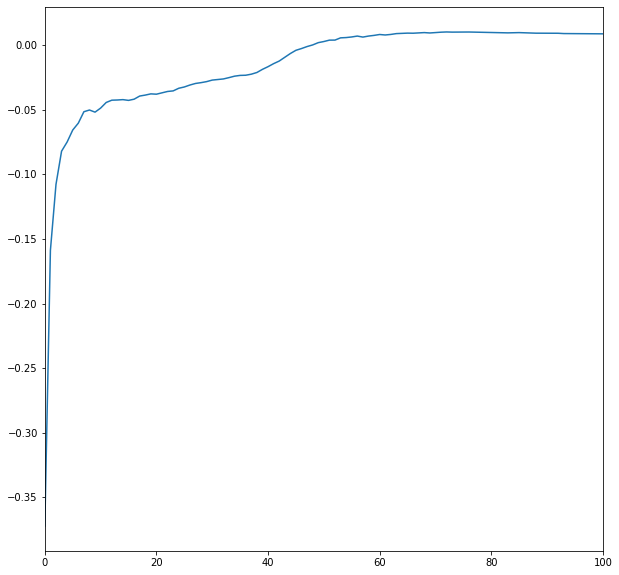

In [ ]:
#difference of lists test_losses and train_losses
diff = [test_losses[i] - train_losses[i] for i in range(len(test_losses))]
plt.figure(figsize=(10, 10))
plt.plot(diff)
#xlim
plt.xlim(0, 100)

In [ ]:
seq = t.tensor([10] * 10).to(cfg.device)
out = model(seq)

In [ ]:
out[:,-1,:]

tensor([[-68.5691, -53.3248, -33.7109,  28.4673, -47.1521,  49.8403,  20.7787,
          18.6870, -19.6562,  14.9037]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
line(test_losses, log_y=True)
# plt.plot(train_losses)

In [ ]:
line(train_losses, log_y=True)

In [ ]:
imshow(model.embed.W_E)

In [ ]:
# Take the dot product of all the embedding vectors
emb = model.embed.W_E
vec_count = emb.shape[0]
vec_dim = emb.shape[1]
print(f"The embedding shape is {emb.shape}, so our vectors of length {emb.shape[1]}")

dot_products = einops.einsum(emb, emb, "v2 embs, v1 emb -> v1 v2")

The embedding shape is torch.Size([11, 128]), so our vectors of length 128


In [ ]:
print(dot_products.shape)
imshow_div(dot_products)

torch.Size([11, 11])


## What would your hypothesis around the attention head activations be based on seeing this?
+ Jack - My poorly informed guess is that tokens with low dot products and/or low norms won't have any strong attentional interaction
+ Omar - I think that corner moves [0, 2, 6, 8] will have similar attention patterns
+ Ari - I think same as Omar, plus center attends to everything, middle edges have attention symmetry too

In [ ]:
tokens = [0,1,2,3,4,6,5,8,7]
# tokens = ([10] * 5) + [1,2,5,8,7]
str_tokens = [str(token) for token in tokens]
logits, cache = model.run_with_cache(torch.tensor(tokens).to('cuda'), remove_batch_dim=True)


In [ ]:
print(type(cache))
attention_pattern = cache["pattern", 0, "attn"]
print(attention_pattern.shape)

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 9, 9])


In [ ]:
cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern)